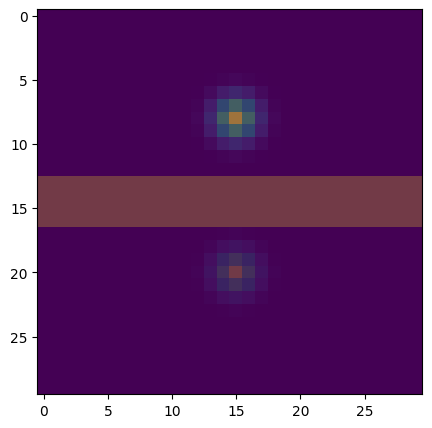

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image


maze = np.zeros((30, 30))
maze[13:17, 0:30] = 1

T = 15
N1 = maze.shape[0]
N2 = maze.shape[1]

H1 = np.repeat(maze[np.newaxis, :, :], T, axis=0) * np.cos(np.pi / 4)
H2 = np.repeat(maze[np.newaxis, :, :], T, axis=0) * np.sin(np.pi / 4)
#H = np.repeat(maze[np.newaxis, :, :], T, axis=0)  # Repeating maze for each time step
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 20./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 8./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

T = 15 # number of time steps
ll = (1.0, 1.0, 1.0) # size of time x space box

xs = []


delta = 2.0

# Wasserstein-Fisher-Rao
x1, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)

#  River constraint
Hs = [np.zeros((T, N1, N2)), H1, H2, np.zeros((T, N1, N2))]
GL = np.zeros((T,))  
GU = np.ones((T,)) * np.inf
x2, lists = computeGeodesic_inequality(rho_0, rho_1, T, ll, H=None, F=None, Hs=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)

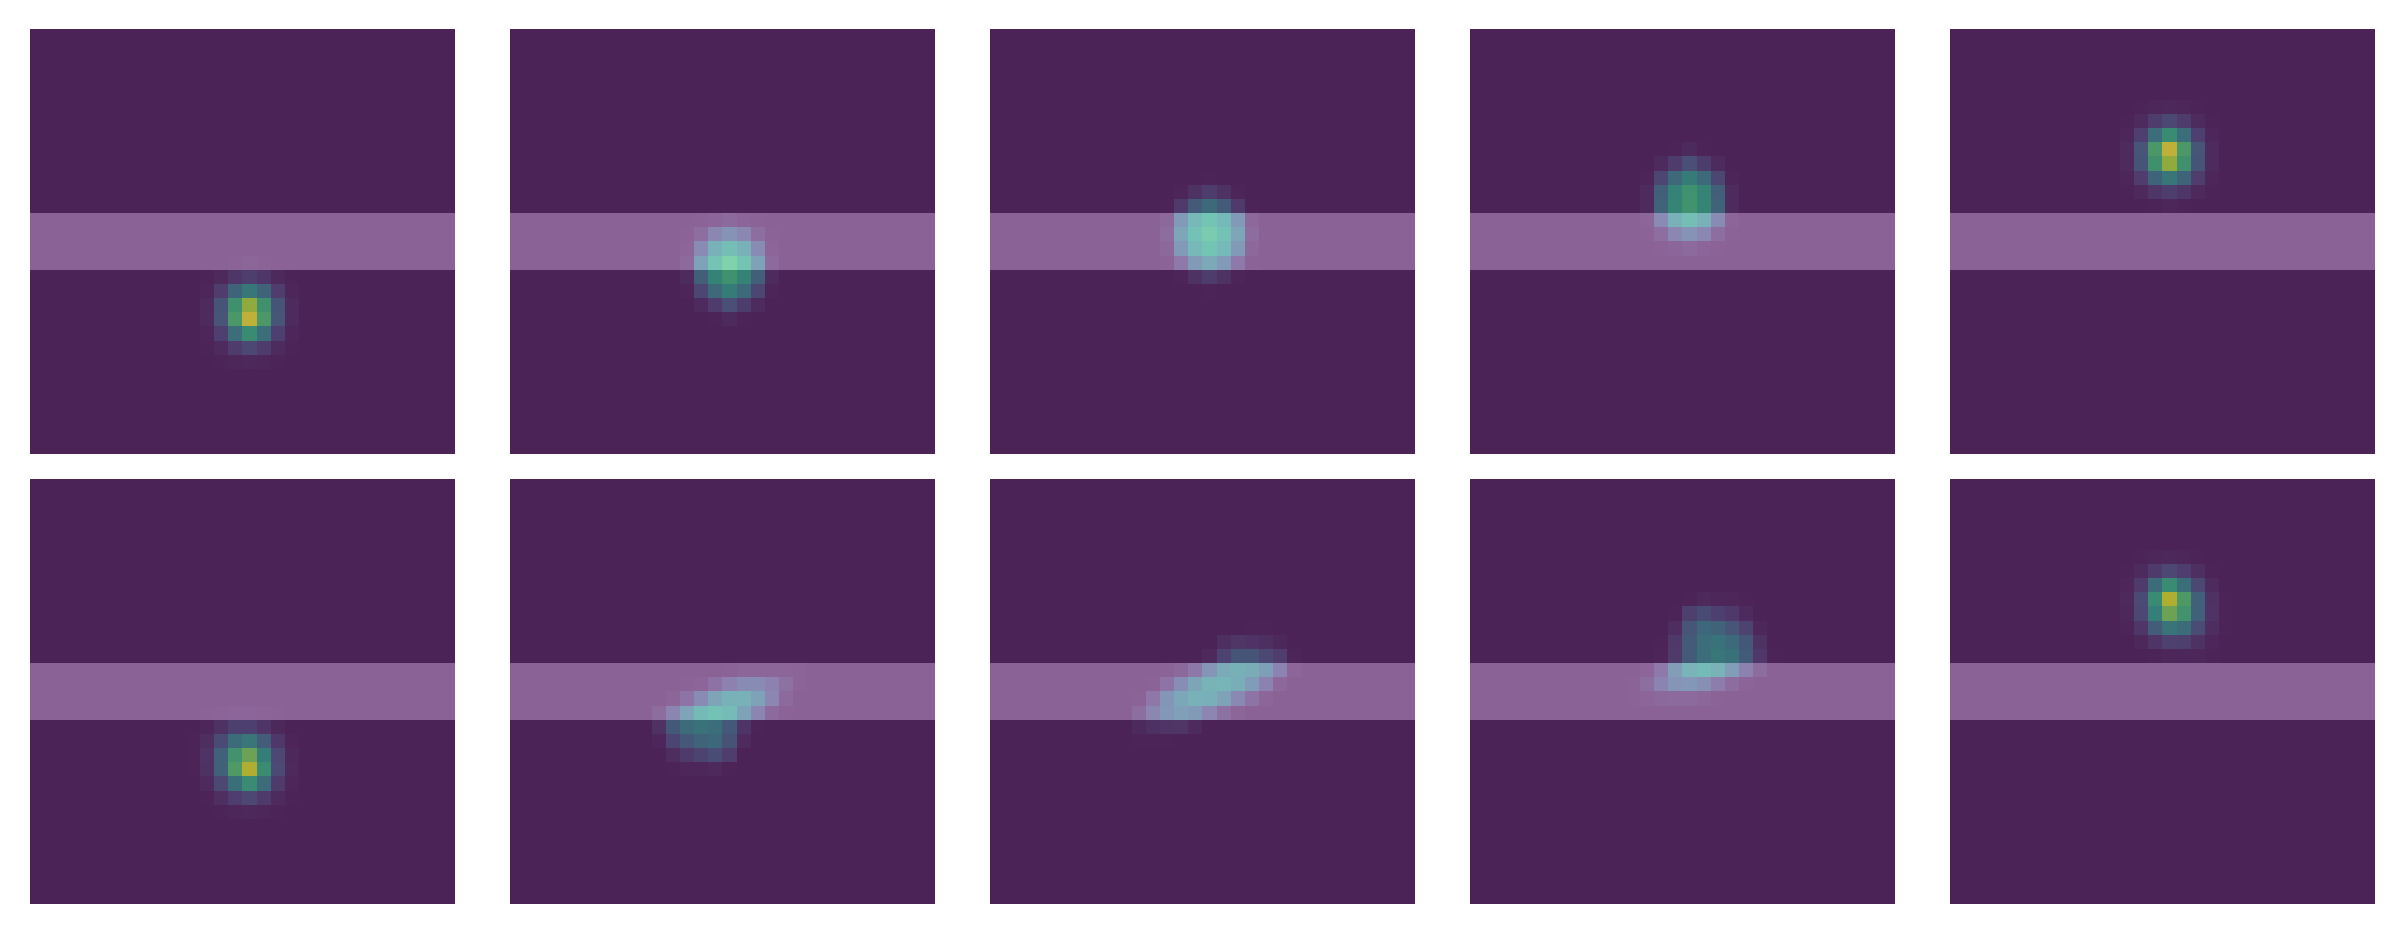

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe  # NEW

# --- Style ---
plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})

# Times to show
fractions = [0.0, 0.25, 0.5, 0.75, 1.0]
T_eff = x1.V.D[0].shape[0]
idxs = [int(round(f * (T_eff - 1))) for f in fractions]

# Grid (row=i, col=j)
N1, N2 = maze.shape
YY, XX = np.meshgrid(np.arange(N1), np.arange(N2), indexing="ij")

# Subsample quiver to reduce clutter
step = 2
XXs = XX[::step, ::step]
YYs = YY[::step, ::step]

# Density scaling (shared)
def _max_over(arr, indices):
    return max(np.max(arr.V.D[0][i]) for i in indices)
vmin, vmax = 0.0, max(_max_over(x1, idxs), _max_over(x2, idxs))
cmap = plt.cm.viridis

# --- Momentum: keep image-style orientation (y downward), optional global flip ---
flip_sign = False  # set True if you want to reverse arrow direction
def get_UV(x, t_idx):
    U = x.V.D[2][t_idx]                 # x / columns
    V = x.V.D[1][t_idx]                 # y / rows (no negation; image-style)
    if flip_sign:
        U, V = -U, -V
    return U, V

# Robust arrow scale + outlier clip
def robust_scale_and_clip(target_len=0.40, clip_pct=99.0):
    mags = []
    for x in (x1, x2):
        for t in idxs:
            U, V = get_UV(x, t)
            M = np.hypot(U[::step, ::step], V[::step, ::step])
            if M.size:
                mags.append(M.ravel())
    M_all = np.concatenate(mags) if mags else np.array([1.0])
    m95   = np.percentile(M_all[M_all > 0], 95) if np.any(M_all > 0) else 1.0
    mcap  = np.percentile(M_all, clip_pct)
    scale = max(m95 / target_len, 1e-12)
    return scale, mcap

qscale, mcap = robust_scale_and_clip(target_len=0.40, clip_pct=99.0)
eps = 1e-12

# Arrow appearance
ARROW_WIDTH = 0.0050
HEAD_W, HEAD_L, HEAD_AX = 10.0, 12.0, 9.0

# --- Figure: 2 rows (Unconstrained / Constrained) × 5 columns (times) ---
fig, axes = plt.subplots(2, len(idxs), figsize=(8, 3), dpi=300, constrained_layout=True)

cmap = plt.cm.viridis
density_alpha = 0.82            # NEW: slightly fade density
ARROW_FACE = "white"            # NEW: high-contrast arrow face
ARROW_EDGE = "black"            # NEW: thin black outline
ARROW_LINEWIDTH = 0.6           # NEW

def draw_row(axrow, x, row_label, show_titles=False):
    for j, t_idx in enumerate(idxs):
        ax = axrow[j]

        # 1) Density (slightly translucent so arrows stand out)
        rho = x.V.D[0][t_idx]
        dens = ax.imshow(
            rho, vmin=vmin, vmax=vmax, cmap=cmap,
            origin="upper",
            extent=[-0.5, N2-0.5, N1-0.5, -0.5],
            interpolation="nearest",
            alpha=density_alpha,               # << here
            zorder=1
        )

        # Maze overlay
        ax.imshow(
            maze, cmap="gray", alpha=0.25, origin="upper",
            extent=[-0.5, N2-0.5, N1-0.5, -0.5], interpolation="nearest",
            zorder=2
        )

        # 2) Momentum (quiver) with white fill + black outline
        U, V = get_UV(x, t_idx)
        Us = U[::step, ::step].copy(); Vs = V[::step, ::step].copy()
        M  = np.hypot(Us, Vs)
        clip_fac = np.minimum(1.0, mcap / (M + eps))
        Us *= clip_fac; Vs *= clip_fac

        rho_s = rho[::step, ::step]
        support = rho_s > (0.003 * rho_s.max())
        Us = np.where(support, Us, 0.0)
        Vs = np.where(support, Vs, 0.0)

        """
        q = ax.quiver(
            XXs, YYs, Us, Vs,
            angles="xy", scale_units="xy", scale=qscale,
            pivot="tail", width=ARROW_WIDTH,
            headwidth=HEAD_W, headlength=HEAD_L, headaxislength=HEAD_AX,
            color=ARROW_FACE,                 # white fill
            linewidths=ARROW_LINEWIDTH,       # edge thickness
            zorder=3
        )

        # Style the single Quiver artist (no .collections here)
        q.set_edgecolor(ARROW_EDGE)           # black outline
        q.set_facecolor(ARROW_FACE)           # keep white fill
        q.set_linewidths(ARROW_LINEWIDTH)

        # Optional: extra crisp outline (works on Collections/Artists)
        q.set_path_effects([
            pe.withStroke(linewidth=ARROW_LINEWIDTH + 0.6, foreground=ARROW_EDGE)
        ])
        """

        # Cosmetics
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-0.5, N2-0.5); ax.set_ylim(N1-0.5, -0.5)
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)

        if show_titles:
            ax.set_title(f"t = {fractions[j]:.2f}", pad=6)
    #axrow[0].set_ylabel(row_label)

# Draw rows
draw_row(axes[0], x1, "Unconstrained", show_titles=False)
draw_row(axes[1], x2, "Constrained",   show_titles=False)

# Shared colorbar for density
#mappable = axes[1, -1].images[0]  # the density image on the last subplot
#cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
#cbar.set_label("Density")

# Save
plt.savefig("figures/river_uot_merged_density_quiver_2x5.png", bbox_inches="tight", dpi=300)
#plt.savefig("figures/river_uot_merged_density_quiver_2x5.pdf", bbox_inches="tight")
plt.show()


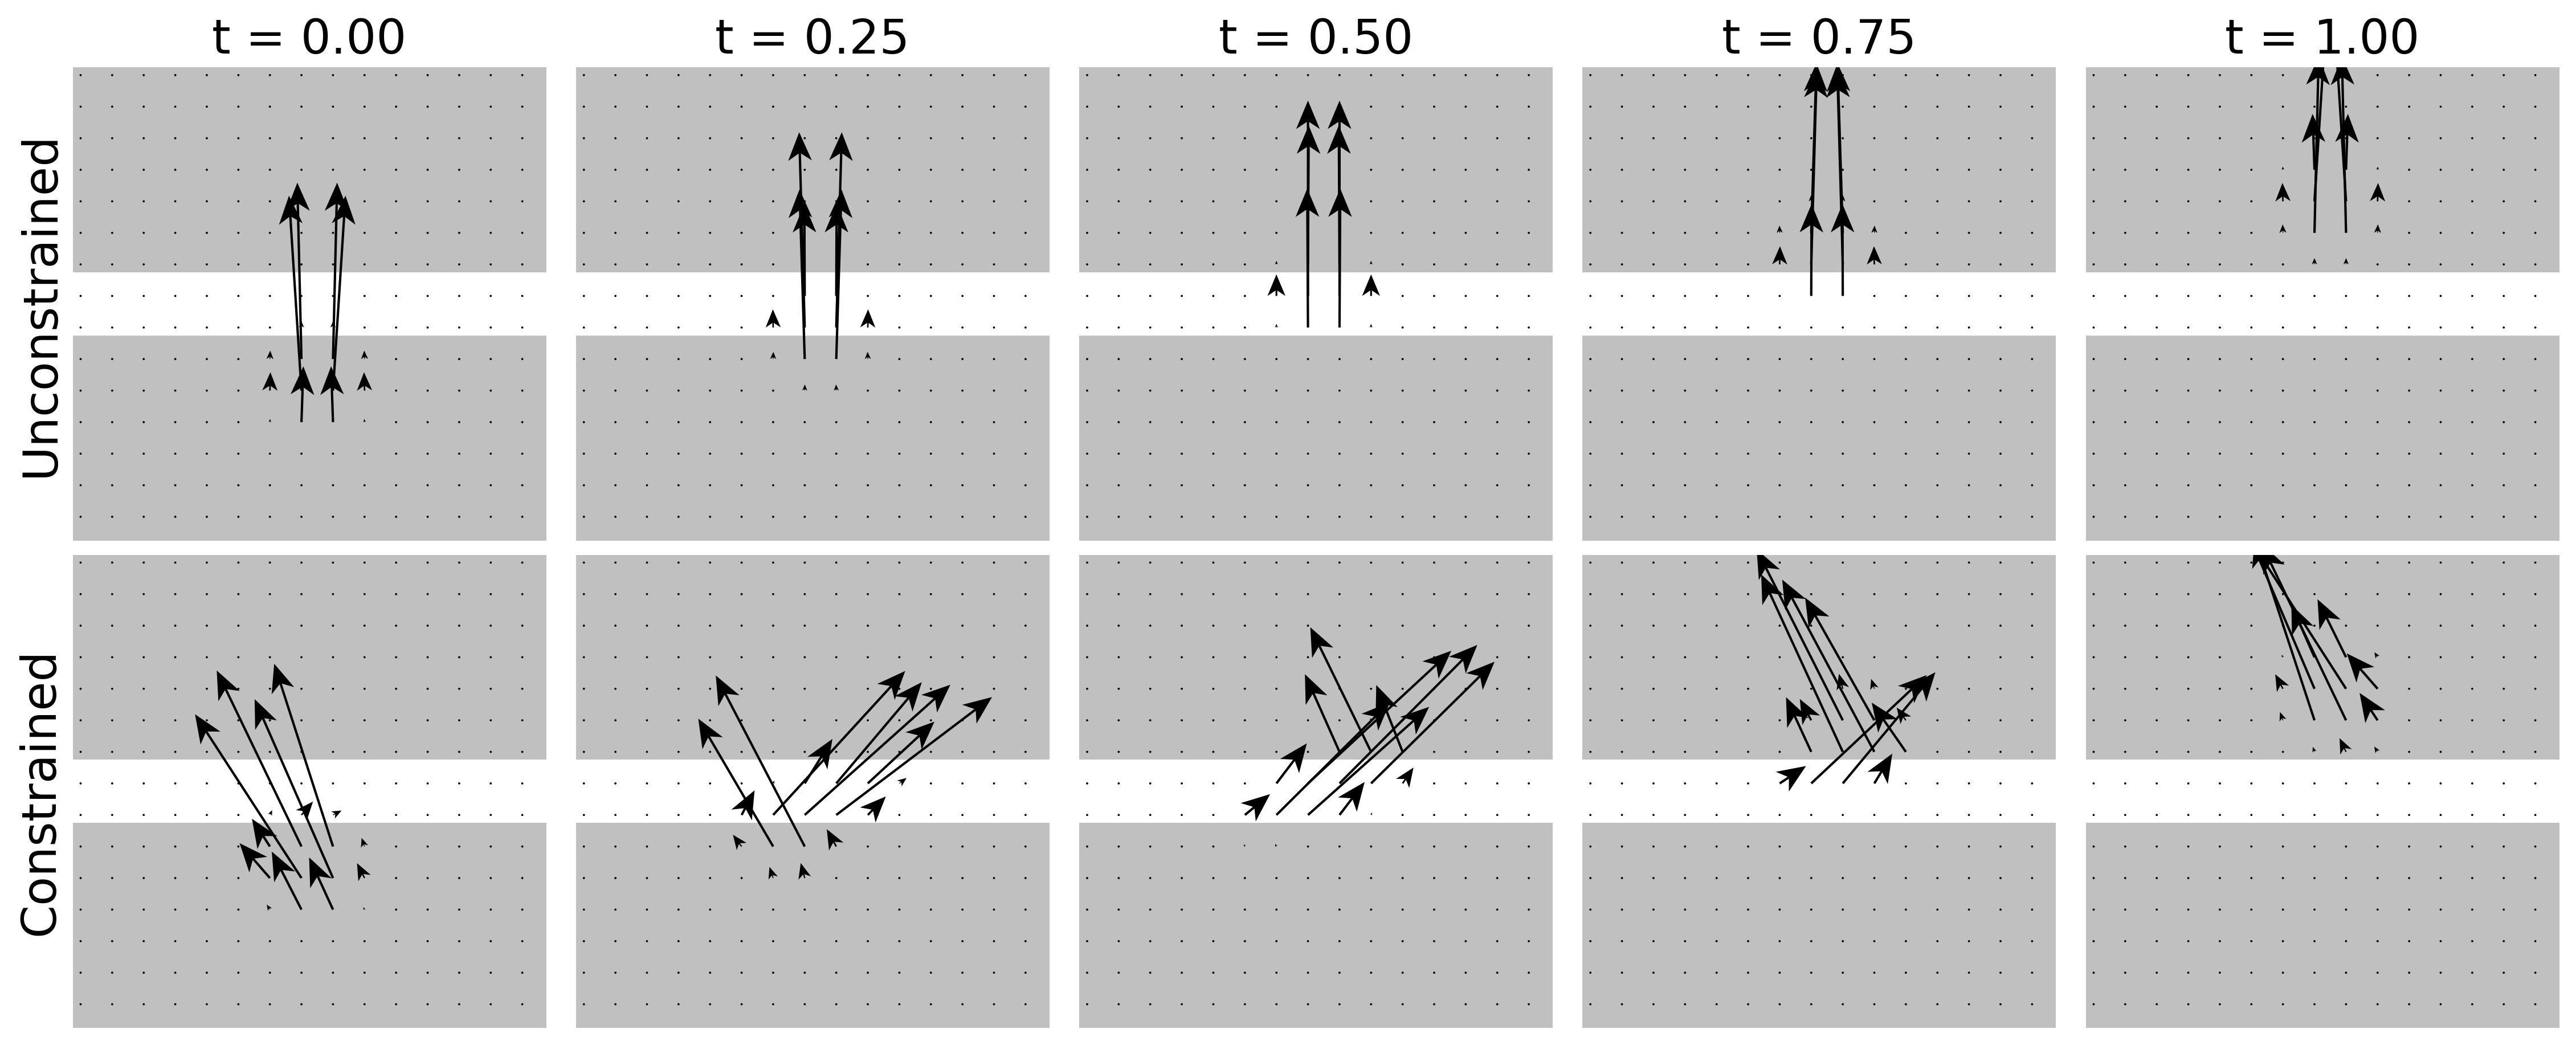

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Style ---
plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})

fractions = [0.0, 0.25, 0.5, 0.75, 1.0]
T_eff = x1.V.D[0].shape[0]
idxs = [int(round(f * (T_eff - 1))) for f in fractions]

# Grid aligned with pixel centers (row=i, col=j)
N1, N2 = maze.shape
YY, XX = np.meshgrid(np.arange(N1), np.arange(N2), indexing="ij")

# Subsample to reduce clutter
step = 2
XXs = XX[::step, ::step]
YYs = YY[::step, ::step]

# --- Direction: keep sign flip, restore original (image) orientation ---
flip_sign = False  # keep this True per your preference

def get_UV(x, t_idx):
    U = x.V.D[2][t_idx]   # x/columns
    V = x.V.D[1][t_idx]   # y/rows (no negation; y points downward like rows)
    if flip_sign:
        U, V = -U, -V
    return U, V

# Robust scale & outlier clip
def robust_scale_and_clip(target_len=0.40, clip_pct=99.0):
    mags = []
    for x in (x1, x2):
        for t in idxs:
            U, V = get_UV(x, t)
            M = np.hypot(U[::step, ::step], V[::step, ::step])
            if M.size:
                mags.append(M.ravel())
    M_all = np.concatenate(mags) if mags else np.array([1.0])
    m95   = np.percentile(M_all[M_all > 0], 95) if np.any(M_all > 0) else 1.0
    mcap  = np.percentile(M_all, clip_pct)
    scale = max(m95 / target_len, 1e-12)
    return scale, mcap

qscale, mcap = robust_scale_and_clip(target_len=0.40, clip_pct=99.0)
eps = 1e-12

# Bigger, clearer arrowheads
ARROW_WIDTH = 0.0050
HEAD_W, HEAD_L, HEAD_AX = 10.0, 12.0, 9.0

def draw_row(axrow, x, row_label):
    for j, t_idx in enumerate(idxs):
        ax = axrow[j]
        U, V = get_UV(x, t_idx)

        # Subsample & clip extremes
        Us = U[::step, ::step].copy()
        Vs = V[::step, ::step].copy()
        M  = np.hypot(Us, Vs)
        clip_fac = np.minimum(1.0, mcap / (M + eps))
        Us *= clip_fac; Vs *= clip_fac

        # Optional: only where density is non-negligible
        rho = x.V.D[0][t_idx][::step, ::step]
        support = rho > (0.003 * rho.max())
        Us = np.where(support, Us, 0.0)
        Vs = np.where(support, Vs, 0.0)

        # Background with original (image) orientation: top-left is (0,0), y goes downward
        ax.imshow(
            maze, cmap="gray", alpha=0.25, origin="upper",
            extent=[-0.5, N2-0.5, N1-0.5, -0.5], interpolation="nearest"
        )

        ax.quiver(
            XXs, YYs, Us, Vs,
            angles="xy", scale_units="xy", scale=qscale,
            pivot="tail", width=ARROW_WIDTH,
            headwidth=HEAD_W, headlength=HEAD_L, headaxislength=HEAD_AX
        )

        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-0.5, N2-0.5)
        ax.set_ylim(N1-0.5, -0.5)  # reversed order → image-style orientation
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
    axrow[0].set_ylabel(row_label)

fig, axes = plt.subplots(2, len(idxs), figsize=(15, 6), dpi=300, constrained_layout=True)
draw_row(axes[0], x1, "Unconstrained")
draw_row(axes[1], x2, "Constrained")
for j, f in enumerate(fractions):
    axes[0, j].set_title(f"t = {f:.2f}", pad=6)

plt.savefig("figures/river_uot_momentum_quiver_2x5.png", bbox_inches="tight", dpi=300)
plt.savefig("figures/river_uot_momentum_quiver_2x5.pdf", bbox_inches="tight")
plt.show()
